<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-first-run" data-toc-modified-id="Simple-first-run-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple first run</a></span></li></ul></div>

In [313]:
import numpy as np
import matplotlib.pyplot as plt

## Simple first run

1. Iniatilize NxN grid
2. Compute the initial energy $E$
3. Flip random spin and compute $\Delta E$
4. Accept or reject based on criteria
5. Continue to 3

In [ ]:
def adjacent_indices_torus(idx, N):
    i, j = idx
    return [
        ((i+1)%N, j),
        ((i-1)%N, j),
        (i, (j+1)%N),
        (i, (j-1)%N),
    ]

def simulate_ising(grid, beta, J, mu):
    # This is not efficient, but is clear to read
    E = 0
    e_0 = 30
    for i in range(N):
        for j in range(N):
            adj_ = adjacent_indices_torus((i,j), N)
            E += sum(-J*grid[i,j]*grid[ix] for ix in adj_)
            E += -mu*grid[i, j]

    averages = []
    energies = []
    print('Starting energy', E)
    for n in range(int(2e3)):
        averages.append(np.mean(grid))
        energies.append(E)
        i, j = (np.random.randint(0, N, size=(2,)))
        x = grid[i, j]
        grid[i, j] = - x
        adj_ = adjacent_indices_torus((i,j), N)
        dE = sum(-J*x*grid[ix] for ix in adj_)
        dE += -mu*x
        dE = -2*dE

        accept_p = min(1, np.exp(-beta*dE))

        if accept_p>np.random.rand():
            E = E + dE
        else:
            #reset it back
            grid[i, j] = x
    return grid, averages, energies

adjacent_indices_torus((1, 20), 20)

In [314]:
# Insight from using full energy
np.seterr(over='raise')

{'divide': 'warn', 'over': 'raise', 'under': 'ignore', 'invalid': 'warn'}

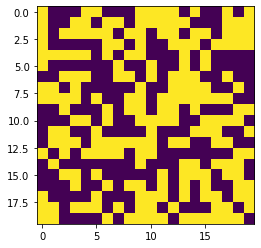

In [325]:
N = 20
grid = np.random.randint(low=0, high=2, size=(N, N))
plt.imshow(grid)
# Rescale to +-1
grid = -1 + 2*grid

In [ ]:
beta = 1/10
J = 10
mu = 1

grid, averages, energies = simulate_ising(grid, beta, J, mu)


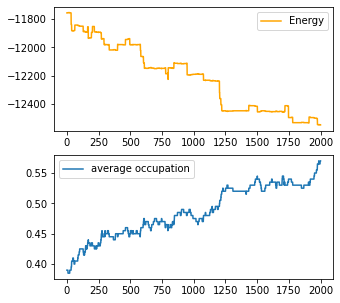

In [333]:
fig, axs = plt.subplots(2,1, figsize=(5,5))
plt.plot(averages, label='average occupation') 
plt.legend()
plt.sca(axs[0])
plt.plot(energies, label='Energy', color='orange') 
plt.legend()

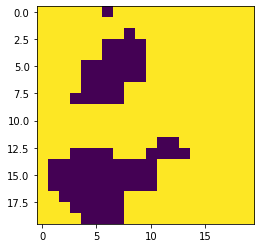

In [334]:
plt.imshow(grid)